In [1]:
# Basic imports
import os,sys,re
from importlib import reload
import numpy as np
import pandas as pd
#import torch
print(os.getpid())

1371270


In [2]:
# ChromAn related imports
sys.path.append(r'/lab/weissman_imaging/puzheng/Softwares/') # parent folder of ChromAn
import ImageAnalysis3 as ia3
import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast
from ChromAn.src import file_io

from ChromAn.src.file_io import dax_process
from ChromAn.src.file_io import data_organization
from ChromAn.src.visual_tools import interactive
from ChromAn.src.correction_tools.alignment import generate_drift_crops
from ChromAn.src.spot_tools.match_spots import colocalize_spots

import pickle

import matplotlib.pyplot as plt

In [3]:
plt.style.use('dark_background')

# Load sequencing analysis output

In [4]:
data_folder = r'/lab/solexa_weissman/puzheng/Sequencing_data/231027_M01799_0469_000000000-L5YYM'
analysis_folder = os.path.join(data_folder, 'Analysis')

In [5]:
# Load probes:
from Bio import SeqIO

probe_filename = os.path.join(analysis_folder, 'MF1-3.fasta')
print(probe_filename)

probes = []
for record in SeqIO.parse(probe_filename, "fasta"):
    probes.append(record)
print(len(probes))

/lab/solexa_weissman/puzheng/Sequencing_data/231027_M01799_0469_000000000-L5YYM/Analysis/MF1-3.fasta
127389


In [6]:
probe_df = pd.DataFrame({
    'name':[ _pb.name for _pb in probes],
    'sequence': [str(_pb.seq) for _pb in probes],
})
probe_df

,name,sequence
0,MF1_Igkc_ENSMUST00000103410.3_shift-0_GC-53.3_...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
1,MF1_Iglc2_ENSMUST00000103749.3_shift-0_GC-50.0...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
2,MF1_Il21_ENSMUST00000029273.8_shift-0_GC-56.6_...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
3,MF1_Xcl1_ENSMUST00000027860.8_shift-0_GC-53.3_...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
4,MF1_S100a10_ENSMUST00000148400.2_shift-0_GC-56...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
...,...,...
127384,MF3-msBrain-immune_Slc4a8_ENSMUST00000023776.1...,CCCGCAATGGCTGACAACCGCCCATGATCGTCCGATCTGGCCCATG...
127385,MF3-msBrain-immune_Mgam_ENSMUST00000238599.2_s...,CCCGCAATGGCTGACAACCGCCCATGATCGTCCGATCTGGCCCATG...
127386,MF3-msBrain-immune_Slc4a8_ENSMUST00000023776.1...,CCCGCAATGGCTGACAACCGCCCATGATCGTCCGATCTGGCCCATG...
127387,MF3-msBrain-immune_Zfp318_ENSMUST00000113481.9...,CCCGCAATGGCTGACAACCGCCCATGATCGTCCGATCTGGCCCATG...


In [7]:
# load analysis 
sequence_folder = os.path.join(data_folder, '20231028_082558', 'Fastq')
alignment_stats = [os.path.join(sequence_folder, _f) for _f in os.listdir(sequence_folder) if 'stat.txt' in _f]
alignment_stats

['/lab/solexa_weissman/puzheng/Sequencing_data/231027_M01799_0469_000000000-L5YYM/20231028_082558/Fastq/MF2-amplified_S2_L001_stat.txt',
 '/lab/solexa_weissman/puzheng/Sequencing_data/231027_M01799_0469_000000000-L5YYM/20231028_082558/Fastq/MF1-amplified_S1_L001_stat.txt',
 '/lab/solexa_weissman/puzheng/Sequencing_data/231027_M01799_0469_000000000-L5YYM/20231028_082558/Fastq/MF3-amplified_S3_L001_stat.txt',
 '/lab/solexa_weissman/puzheng/Sequencing_data/231027_M01799_0469_000000000-L5YYM/20231028_082558/Fastq/MF2-twist_S5_L001_stat.txt',
 '/lab/solexa_weissman/puzheng/Sequencing_data/231027_M01799_0469_000000000-L5YYM/20231028_082558/Fastq/MF1-twist_S4_L001_stat.txt',
 '/lab/solexa_weissman/puzheng/Sequencing_data/231027_M01799_0469_000000000-L5YYM/20231028_082558/Fastq/MF3-twist_S6_L001_stat.txt']

## MF1

In [83]:
# Analysis for MF1:
library_name = 'MF1'
lib_probe_df = probe_df.loc[
    np.array([library_name in _n for _n in probe_df['name']])
]

amplified_pool_stat = pd.read_table([_f for _f in alignment_stats if library_name in _f and 'amplified' in _f][0],
                                    header=None, names=['ref', 'length', 'mapped', 'unmapped'])
lib_amplified_match_df = amplified_pool_stat.loc[
    np.array([library_name in _n for _n in probe_df['name']]+[False])
]
lib_amplified_match_df = pd.concat([lib_amplified_match_df, lib_probe_df], axis=1)
len(lib_amplified_match_df), amplified_pool_stat['mapped'].sum(), amplified_pool_stat['unmapped'].sum()

(27116, 648064, 170638)

In [84]:
np.mean(lib_amplified_match_df['mapped']), np.sum(lib_amplified_match_df['mapped']==0) / len(lib_amplified_match_df)

(23.677054137778434, 0.5813541820327482)

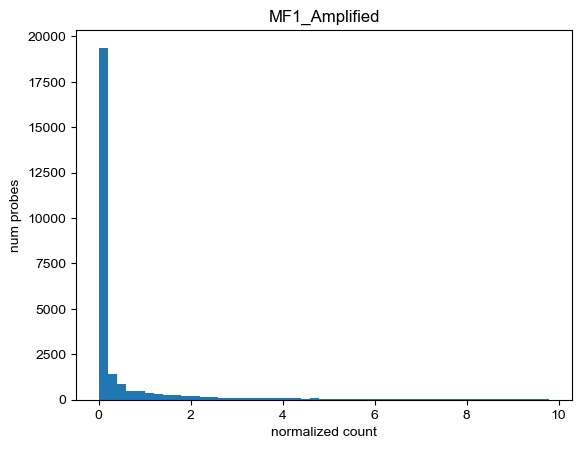

In [85]:
plt.figure()
plt.hist(lib_amplified_match_df['mapped'].values / np.mean(lib_amplified_match_df['mapped']), 
         bins=np.arange(0,10, 0.2))
plt.xlabel('normalized count')
plt.ylabel('num probes')
plt.title(f"{library_name}_Amplified")
plt.show()

In [86]:
# split by gene
gene_2_amplified_match_df = {}
for _i, _row in lib_amplified_match_df.iterrows():
      _gene = _row['name'].split('_')[1]
      if _gene not in gene_2_amplified_match_df:
            gene_2_amplified_match_df[_gene] = [_row['mapped']]
      else:
            gene_2_amplified_match_df[_gene].append(_row['mapped'])
      

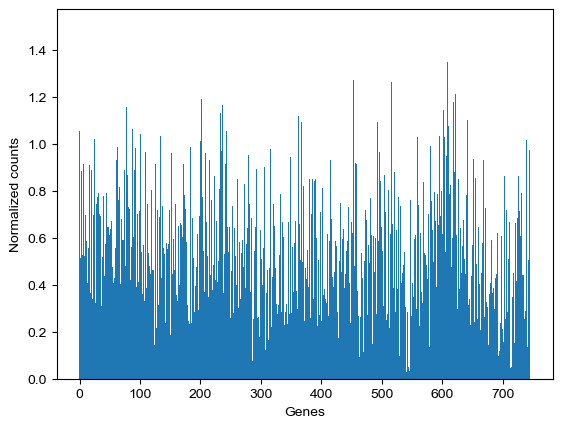

In [87]:
plt.figure()
gene_total_counts = [np.sum(_v)/np.mean(lib_amplified_match_df['mapped'])/len(_v) for _v in gene_2_amplified_matches.values()]
plt.bar(np.arange(len(gene_total_counts)), gene_total_counts, width=1)
plt.xlabel('Genes')
plt.ylabel('Normalized counts')
#for _gene, _counts in gene_2_amplified_matches.items():
#    plt.hist(_counts, bins=np.arange(0,100, 5), label=f"{_gene}")
plt.show()
    

['Stv_3',
 'Stv_4',
 'Stv_5',
 'Stv_6',
 'Stv_7',
 'Stv_8',
 'Stv_9',
 'Stv_10',
 'Stv_11',
 'Stv_12',
 'Stv_13',
 'Stv_14',
 'Stv_16',
 'Stv_19',
 'Stv_20',
 'Stv_21',
 'Stv_22',
 'Stv_23',
 'Stv_25',
 'Stv_26',
 'Stv_27',
 'Stv_28']

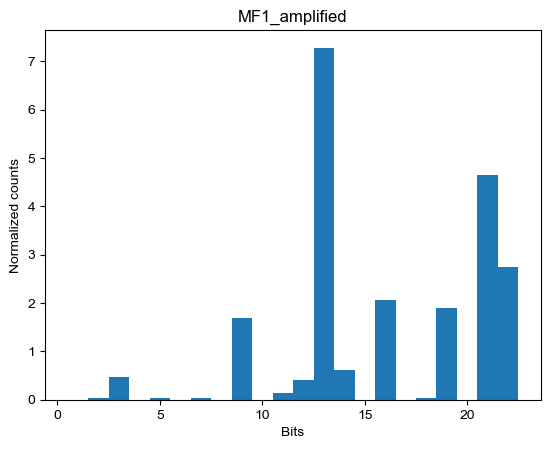

In [93]:
# split by probe
probe_2_amplified_matches = {}
for _i, _row in lib_amplified_match_df.iterrows():
      _probe = _row['name'].split('-')[-1]
      if _probe not in probe_2_amplified_matches:
            probe_2_amplified_matches[_probe] = [_row['mapped']]
      else:
            probe_2_amplified_matches[_probe].append(_row['mapped'])
probes = [_k for _k in sorted(probe_2_amplified_matches.keys(), key=lambda v:int(v.split('_')[1]))]
probe_total_counts = [np.sum(probe_2_amplified_matches[_p])/np.mean(lib_amplified_match_df['mapped'])/len(probe_2_amplified_matches[_p]) 
                      for _p in probes]

plt.figure()
plt.bar(np.arange(len(probe_total_counts))+1, probe_total_counts, width=1)
plt.xlabel('Bits')
plt.ylabel('Normalized counts')
plt.title(f"{library_name}_amplified")
#for _gene, _counts in gene_2_amplified_matches.items():
#    plt.hist(_counts, bins=np.arange(0,100, 5), label=f"{_gene}")
plt.show()

In [131]:
twist_pool_stat = pd.read_table([_f for _f in alignment_stats if library_name in _f and 'twist' in _f][0],
                                    header=None, names=['ref', 'length', 'mapped', 'unmapped'])
lib_twist_match_df = twist_pool_stat.loc[
    np.array([library_name in _n for _n in probe_df['name']]+[False])
]
len(lib_twist_match_df), twist_pool_stat['mapped'].sum(), twist_pool_stat['unmapped'].sum()

(27116, 322808, 54365)

In [132]:
np.mean(lib_twist_match_df['mapped']), np.sum(lib_twist_match_df['mapped']==0) / len(lib_twist_match_df)

(11.770504499188672, 0.005089246201504647)

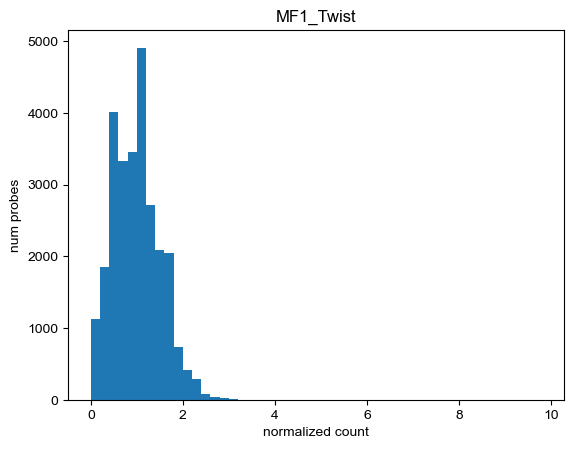

In [133]:
plt.figure()
plt.hist(lib_twist_match_df['mapped'].values / np.mean(lib_twist_match_df['mapped']), 
         bins=np.arange(0,10, 0.2))
plt.xlabel('normalized count')
plt.ylabel('num probes')
plt.title(f"{library_name}_Twist")
plt.show()

## MF2

In [8]:
# Analysis for MF2:
library_name = 'MF2'
lib_probe_df = probe_df.loc[
    np.array([library_name in _n for _n in probe_df['name']])
]

amplified_pool_stat = pd.read_table([_f for _f in alignment_stats if library_name in _f and 'amplified' in _f][0],
                                    header=None, names=['ref', 'length', 'mapped', 'unmapped'])
lib_amplified_match_df = amplified_pool_stat.loc[
    np.array([library_name in _n for _n in probe_df['name']]+[False])
]
lib_amplified_match_df = pd.concat([lib_amplified_match_df, lib_probe_df], axis=1)
len(lib_amplified_match_df), amplified_pool_stat['mapped'].sum(), amplified_pool_stat['unmapped'].sum()

(66321, 884232, 67592)

In [9]:
lib_amplified_match_df

,ref,length,mapped,unmapped,name,sequence
27116,27116,150,20,0,MF2-4T1-primary_Gna14_ENSMUST00000025602.4_shi...,CGCAAACTGGTGCGGAAGGCGGATATCGACCGGAAGTCCAGGATAT...
27117,27117,150,31,0,MF2-4T1-primary_Plvap_ENSMUST00000048452.6_shi...,CGCAAACTGGTGCGGAAGGCGGATATCGACCGGAAGTCCAGGATAT...
27118,27118,150,30,0,MF2-4T1-primary_Eomes_ENSMUST00000111763.8_shi...,CGCAAACTGGTGCGGAAGGCGGATATCGACCGGAAGTCCAGGATAT...
27119,27119,150,24,0,MF2-4T1-primary_Serpine1_ENSMUST00000041388.11...,CGCAAACTGGTGCGGAAGGCGGATATCGACCGGAAGTCCAGGATAT...
27120,27120,150,28,0,MF2-4T1-primary_Gata3_ENSMUST00000102976.4_shi...,CGCAAACTGGTGCGGAAGGCGGATATCGACCGGAAGTCCAGGATAT...
...,...,...,...,...,...,...
93432,93432,150,8,0,MF2-4T1-primary_Syne1_ENSMUST00000215295.2_shi...,CGCAAACTGGTGCGGAAGGCATCCGTAGACCAACCGGCCGATCCGT...
93433,93433,150,16,0,MF2-4T1-primary_Syne1_ENSMUST00000215295.2_shi...,CGCAAACTGGTGCGGAAGGCATCCGTAGACCAACCGGCCGATCCGT...
93434,93434,150,20,0,MF2-4T1-primary_Syne1_ENSMUST00000215295.2_shi...,CGCAAACTGGTGCGGAAGGCATCCGTAGACCAACCGGCCGATCCGT...
93435,93435,150,22,0,MF2-4T1-primary_Syne1_ENSMUST00000215295.2_shi...,CGCAAACTGGTGCGGAAGGCATCCGTAGACCAACCGGCCGATCCGT...


In [10]:
np.mean(lib_amplified_match_df['mapped']), np.sum(lib_amplified_match_df['mapped']==0) / len(lib_amplified_match_df)

(13.319250312872242, 0.18678849836401742)

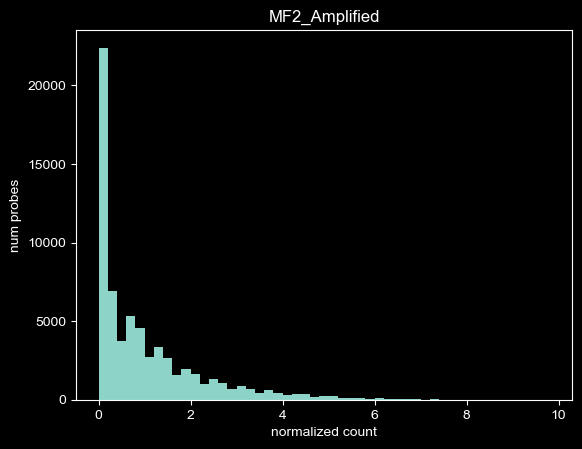

In [11]:
plt.figure()
plt.hist(lib_amplified_match_df['mapped'].values / np.mean(lib_amplified_match_df['mapped']), 
         bins=np.arange(0,10, 0.2))
plt.xlabel('normalized count')
plt.ylabel('num probes')
plt.title(f"{library_name}_Amplified")
plt.show()

In [12]:
# split by gene
gene_2_amplified_matches = {}
for _i, _row in lib_amplified_match_df.iterrows():
      _gene = _row['name'].split('_')[1]
      if _gene not in gene_2_amplified_matches:
            gene_2_amplified_matches[_gene] = [_row['mapped']]
      else:
            gene_2_amplified_matches[_gene].append(_row['mapped'])
      

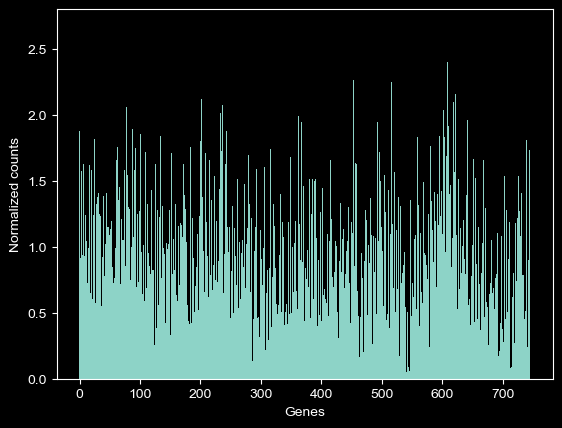

In [13]:
plt.figure()
gene_total_counts = [np.sum(_v)/np.mean(lib_amplified_match_df['mapped'])/len(_v) for _v in gene_2_amplified_matches.values()]
plt.bar(np.arange(len(gene_total_counts)), gene_total_counts, width=1)
plt.xlabel('Genes')
plt.ylabel('Normalized counts')
#for _gene, _counts in gene_2_amplified_matches.items():
#    plt.hist(_counts, bins=np.arange(0,100, 5), label=f"{_gene}")
plt.show()
    

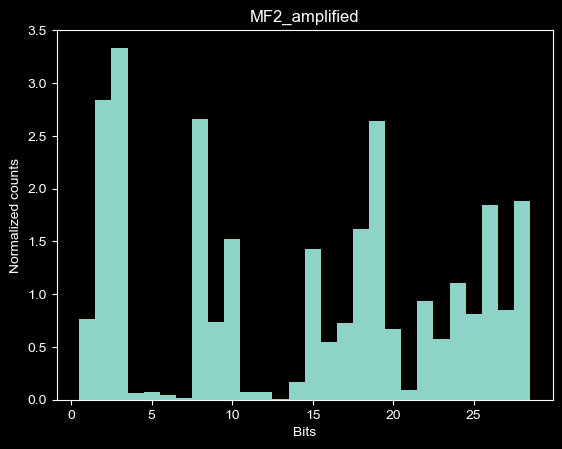

In [14]:
# split by probe
probe_2_amplified_matches = {}
for _i, _row in lib_amplified_match_df.iterrows():
    _probe = _row['name'].split('-')[-1]
    if _probe not in probe_2_amplified_matches:
        probe_2_amplified_matches[_probe] = [_row['mapped']]
    else:
        probe_2_amplified_matches[_probe].append(_row['mapped'])
probes = [_k for _k in sorted(probe_2_amplified_matches.keys())]
probe_total_counts = [np.sum(probe_2_amplified_matches[_p])/np.mean(lib_amplified_match_df['mapped'])/len(probe_2_amplified_matches[_p]) 
                      for _p in probes]

plt.figure()
plt.bar(np.arange(len(probe_total_counts))+1, probe_total_counts, width=1)
plt.xlabel('Bits')
plt.ylabel('Normalized counts')
plt.title(f"{library_name}_amplified")
#for _gene, _counts in gene_2_amplified_matches.items():
#    plt.hist(_counts, bins=np.arange(0,100, 5), label=f"{_gene}")
plt.show()

In [15]:
# Analysis for MF2:
twist_pool_stat = pd.read_table([_f for _f in alignment_stats if library_name in _f and 'twist' in _f][0],
                                    header=None, names=['ref', 'length', 'mapped', 'unmapped'])
lib_twist_match_df = twist_pool_stat.loc[
    np.array([library_name in _n for _n in probe_df['name']]+[False])
]
len(lib_twist_match_df), twist_pool_stat['mapped'].sum(), twist_pool_stat['unmapped'].sum()

(66321, 1090472, 72711)

In [16]:
np.mean(lib_twist_match_df['mapped']), np.sum(lib_twist_match_df['mapped']==0) / len(lib_twist_match_df)

(16.427421178812143, 0.00033171996803425764)

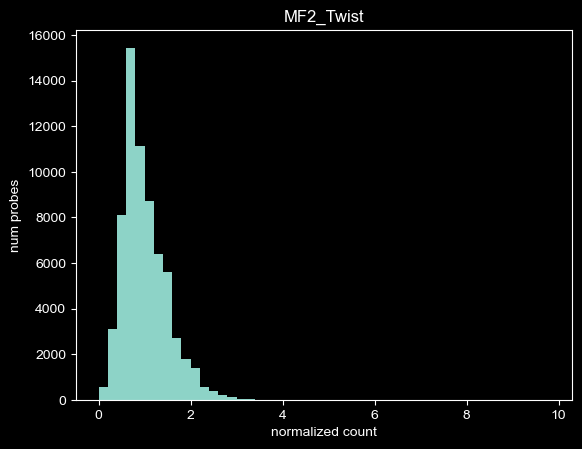

In [17]:
plt.figure()
plt.hist(lib_twist_match_df['mapped'].values / np.mean(lib_twist_match_df['mapped']), 
         bins=np.arange(0,10, 0.2))
plt.xlabel('normalized count')
plt.ylabel('num probes')
plt.title(f"{library_name}_Twist")
plt.show()

In [18]:
lib_twist_match_df = pd.concat([lib_twist_match_df, lib_probe_df], axis=1)

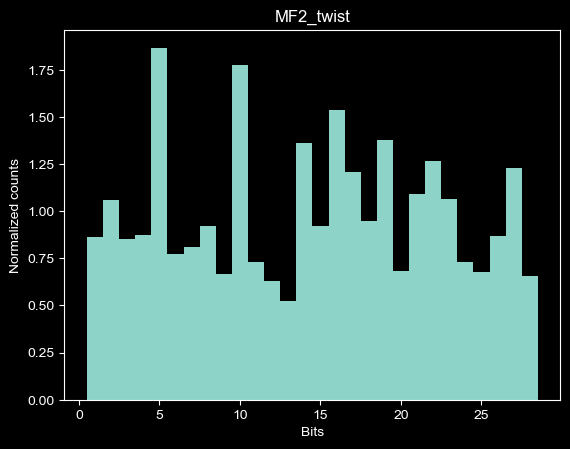

In [19]:
# split by probe
probe_2_twist_matches = {}
for _i, _row in lib_twist_match_df.iterrows():
      _probe = _row['name'].split('-')[-1]
      if _probe not in probe_2_twist_matches:
            probe_2_twist_matches[_probe] = [_row['mapped']]
      else:
            probe_2_twist_matches[_probe].append(_row['mapped'])
probes = [_k for _k in sorted(probe_2_twist_matches.keys())]
probe_total_counts = [np.sum(probe_2_twist_matches[_p])/np.mean(lib_twist_match_df['mapped'])/len(probe_2_twist_matches[_p]) 
                      for _p in probes]

plt.figure()
plt.bar(np.arange(len(probe_total_counts))+1, probe_total_counts, width=1)
plt.xlabel('Bits')
plt.ylabel('Normalized counts')
plt.title(f"{library_name}_twist")
#for _gene, _counts in gene_2_amplified_matches.items():
#    plt.hist(_counts, bins=np.arange(0,100, 5), label=f"{_gene}")
plt.show()

In [124]:
# plot against readout QC:
readouts = pd.read_csv(r'/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF2_4T1Primary/readouts.csv')
from Bio.SeqUtils import MeltingTemp as mt
from Bio.SeqUtils import GC

In [127]:
Tms, GCs = [], []
for _seq in readouts['Sequence']:
      Tms.append(mt.Tm_NN(_seq))
      GCs.append(GC(_seq))


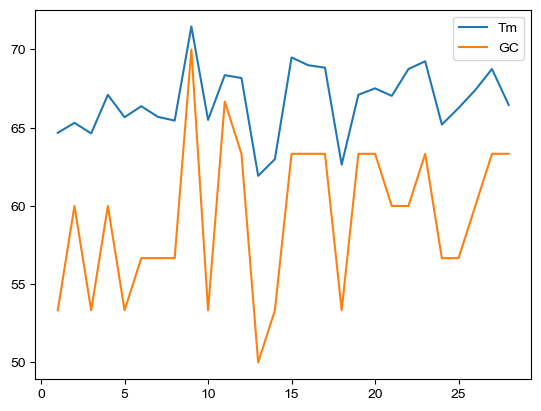

In [134]:
plt.figure()
plt.plot(np.arange(1,29), Tms, label='Tm')
plt.plot(np.arange(1,29), GCs, label='GC')
plt.legend()

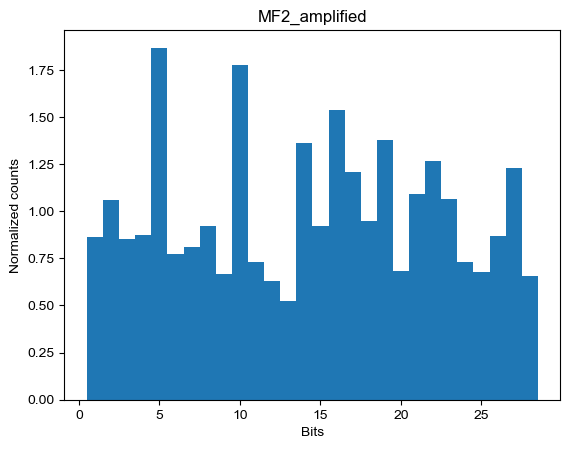

In [126]:
plt.figure()
plt.bar(np.arange(len(probe_total_counts))+1, probe_total_counts, width=1)
plt.xlabel('Bits')
plt.ylabel('Normalized counts')
plt.title(f"{library_name}_amplified")
#for _gene, _counts in gene_2_amplified_matches.items():
#    plt.hist(_counts, bins=np.arange(0,100, 5), label=f"{_gene}")
plt.show()

## MF3

In [140]:
# Analysis for MF2:
library_name = 'MF3'
amplified_pool_stat = pd.read_table([_f for _f in alignment_stats if library_name in _f and 'amplified' in _f][0],
                                    header=None, names=['ref', 'length', 'mapped', 'unmapped'])
lib_amplified_match_df = amplified_pool_stat.loc[
    np.array([library_name in _n for _n in probe_df['name']]+[False])
]
len(lib_amplified_match_df), amplified_pool_stat['mapped'].sum(), amplified_pool_stat['unmapped'].sum()

(33952, 22164, 2150456)

In [141]:
np.mean(lib_amplified_match_df['mapped']), np.sum(lib_amplified_match_df['mapped']==0) / len(lib_amplified_match_df)

(0.5526036757775683, 0.8373586239396795)

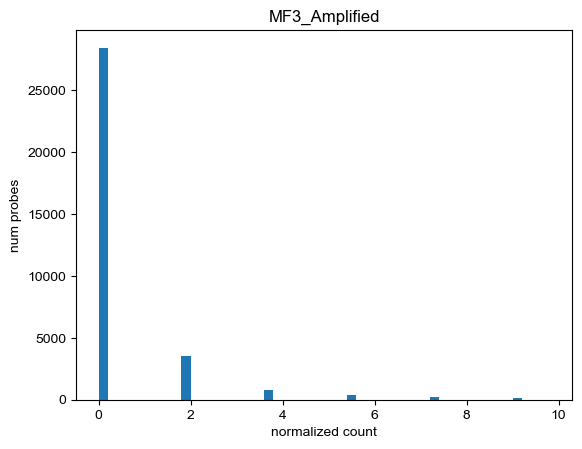

In [142]:
plt.figure()
plt.hist(lib_amplified_match_df['mapped'].values / np.mean(lib_amplified_match_df['mapped']), 
         bins=np.arange(0,10, 0.2))
plt.xlabel('normalized count')
plt.ylabel('num probes')
plt.title(f"{library_name}_Amplified")
plt.show()

In [143]:
# Analysis for MF1:
twist_pool_stat = pd.read_table([_f for _f in alignment_stats if library_name in _f and 'twist' in _f][0],
                                    header=None, names=['ref', 'length', 'mapped', 'unmapped'])
lib_twist_match_df = twist_pool_stat.loc[
    np.array([library_name in _n for _n in probe_df['name']]+[False])
]
len(lib_twist_match_df), twist_pool_stat['mapped'].sum(), twist_pool_stat['unmapped'].sum()

(33952, 535886, 48991)

In [144]:
np.mean(lib_twist_match_df['mapped']), np.sum(lib_twist_match_df['mapped']==0) / len(lib_twist_match_df)

(15.693272855796419, 0.0006479736098020736)

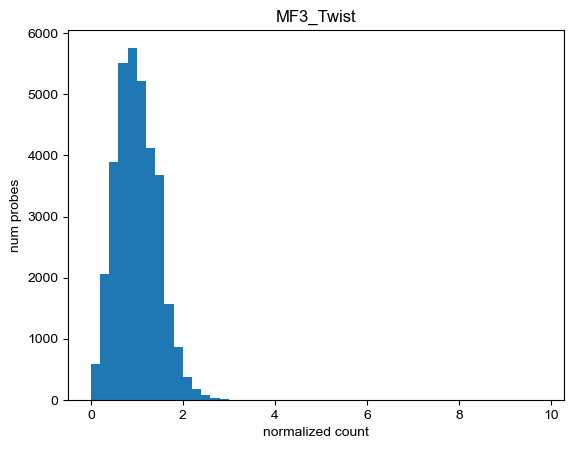

In [145]:
plt.figure()
plt.hist(lib_twist_match_df['mapped'].values / np.mean(lib_twist_match_df['mapped']), 
         bins=np.arange(0,10, 0.2))
plt.xlabel('normalized count')
plt.ylabel('num probes')
plt.title(f"{library_name}_Twist")
plt.show()